In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

%run './../split_step_fourier.ipynb'
DEBUG = False
DEBUG_PLOT = False

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (25, 15)
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# parameters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample, ir = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

P_in = 19 # dBm

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 30 # number of symbols


# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)


# Sendesignal generieren
send_ir = generate_signal(modulation, t_sample, 1/f_symbol, send_bits, ir, syms_per_filt)

# add zeros before and after signal (use samples per symbol as factor)
send = zeroing(send_ir, 200 * int(1/f_symbol/t_sample))

In [3]:
## Transmission parameters
full_distance = 770

z_length = 70  # [km]
nz_max = 10  # steps

alpha = 0  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [4]:
outputs = {}

for nz in range(1,nz_max+1):
    dz = z_length / nz  # [km]
    if DEBUG:
        print(f"Steps per fiber-segment: {nz}")
        
    # put an amplifier every z_length km in the fiber
    next_input = amplifier(send, P_in, t_sample, 1/f_symbol)

    for segment in range(int(full_distance / z_length)):
        segment_output = splitstepfourier(next_input, t_sample, dz, nz, alpha, beta2, gamma)

        if DEBUG:
            print(f"Segment {segment+1} output values: {segment_output}")
        if DEBUG_PLOT:
            plt.plot(np.real(segment_output), label="Real")
            plt.plot(np.imag(segment_output), label="Imag")
            plt.legend()
            plt.show()
        
        if full_distance%z_length == 0 and segment+1 == int(full_distance/z_length):
            final_output = segment_output
        else:
            next_input = amplifier(segment_output, P_in, t_sample, 1/f_symbol)
        
    if full_distance % z_length != 0:
        rest_z_length = full_distance % z_length
        rest_dz = rest_z_length / nz
        rest_output = splitstepfourier(next_input, t_sample, rest_dz, nz, alpha, beta2, gamma)
        
        if DEBUG:
            print(f"last Segment ({rest_z_length} km) output values: {rest_output}")
        if DEBUG_PLOT:
            plt.plot(np.real(rest_output), label="Real")
            plt.plot(np.imag(rest_output), label="Imag")
            plt.legend()
            plt.show()
        
        final_output = rest_output
    
    outputs[f'{nz}'] = final_output
        
        

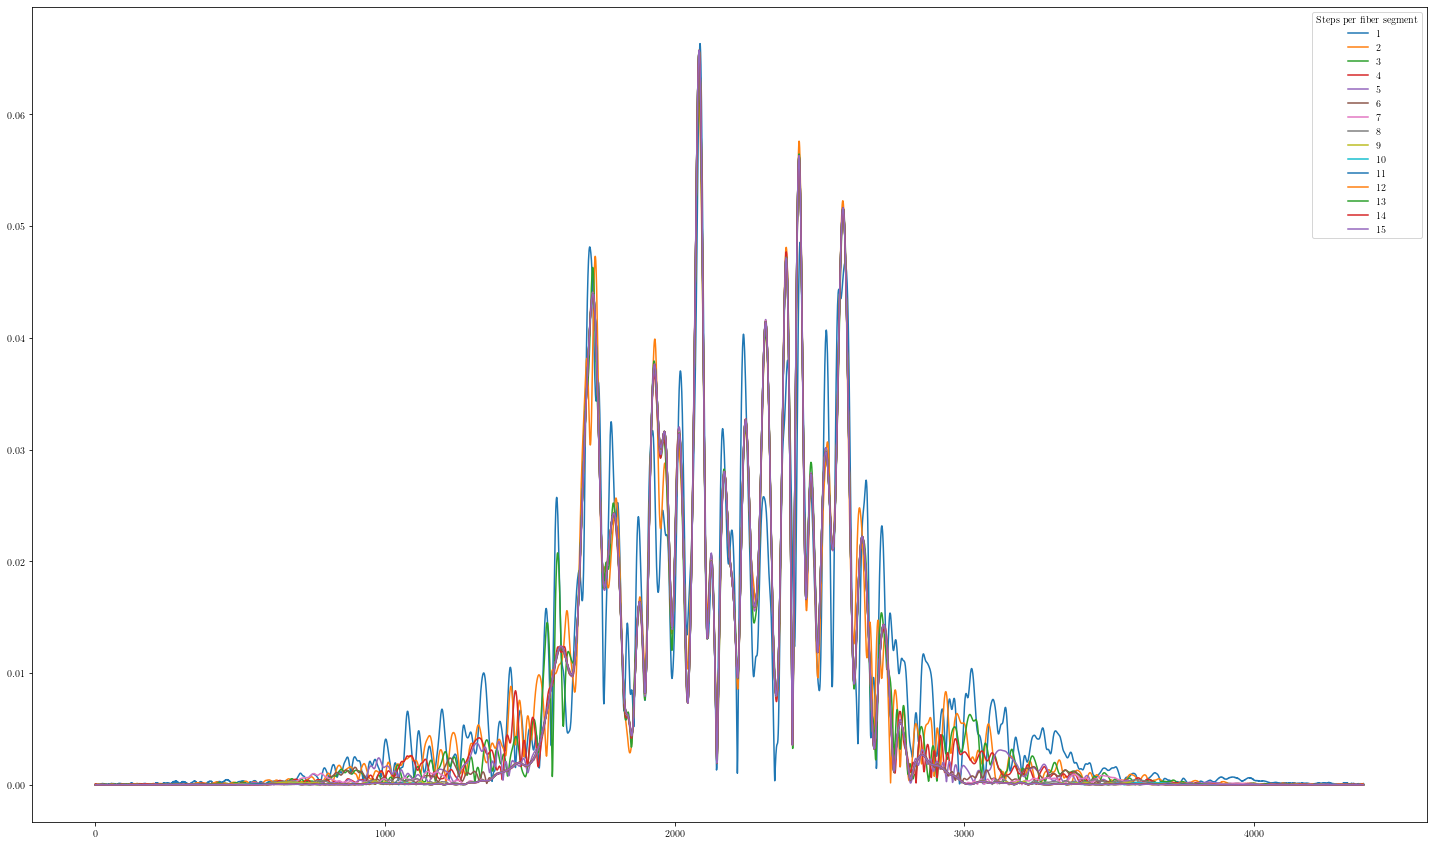

In [5]:
fig1, ax1 = plt.subplots(1, figsize=figure_size)

for key, val in outputs.items():
    ax1.plot(np.abs(val), label=key)
    
ax1.legend(title="Steps per fiber segment")

(1, 15)

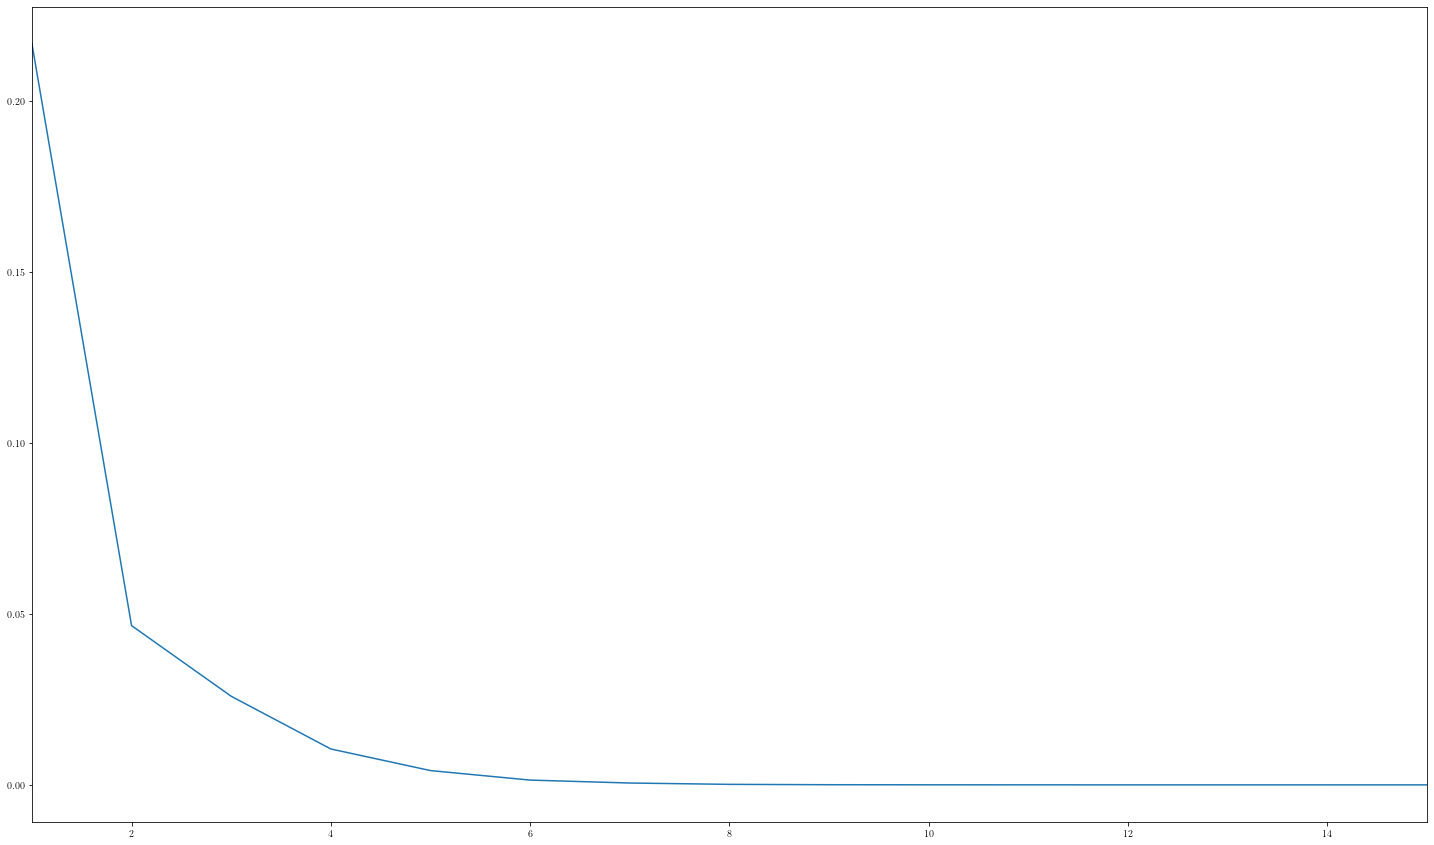

In [6]:
ref = outputs[f'{nz_max}']

errors = [calc_relerr(value, ref) for value in outputs.values()]
x_vals = [int(x) for x in outputs.keys()]

fig2, ax2 = plt.subplots(1, figsize=figure_size)

ax2.plot(x_vals, errors)
ax2.set_xlim(np.amin(x_vals), np.amax(x_vals))

In [7]:
tikzplotlib.save('../../../bachelorarbeit-ausarbeitung/figures/plots/long_distance_step_sweep_outputs.tex', figure=fig1, figureheight="\\figheight", figurewidth="\\figwidth")
tikzplotlib.save('../../../bachelorarbeit-ausarbeitung/figures/plots/long_distance_step_sweep_error.tex', figure=fig2, figureheight="\\figheight", figurewidth="\\figwidth")